# Определение возраста покупателей

## Описание проекта

Исполнитель: Троицкий Илья
Дата: 26 августа 2023 года

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Загрузка данных

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


### Анализ данных

In [4]:
print(labels.shape)

(7591, 2)


In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

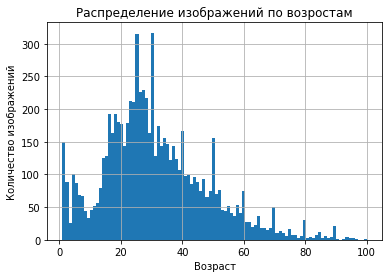

In [9]:
ax = labels['real_age'].hist(bins=100)
plt.title('Распределение изображений по возростам')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.show()

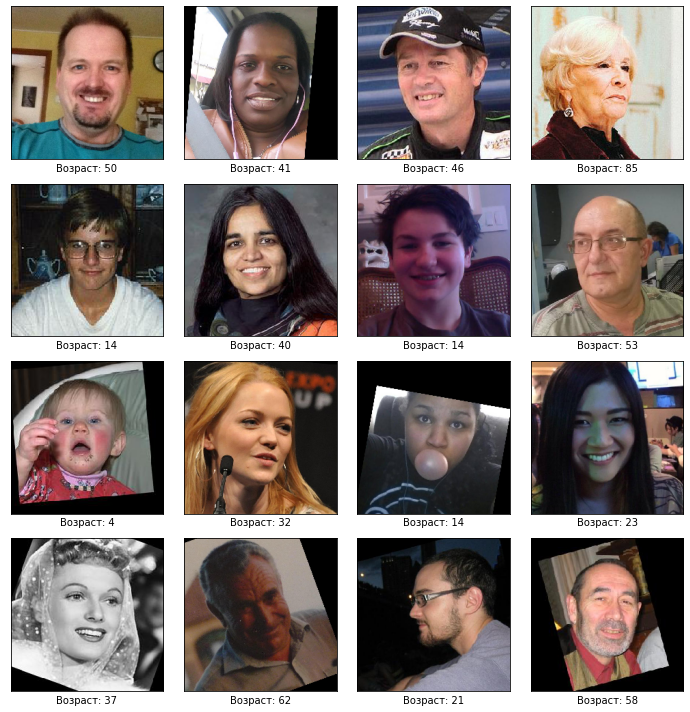

In [7]:
features, target = train_datagen_flow.next()

# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xlabel('Возраст: {}'.format(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод
В датасете 7591 изображения людей возрастом от 1 до 100 лет. Больше всего изображений людей от 24 до 34 лет. Есть фотографии черно-белые. Есть фотографии повернутые на небольшой угол, но это не тербует дополнительной обработки фотографий.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

def load_train(path):
    print(path)
    df = pd.read_csv(f'{path}/labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25,  
                                       rescale=1./255,
                                       horizontal_flip=True 
                                       #vertical_flip=True 
                                       #rotation_range=90, 
                                       #width_shift_range=0.3, 
                                       #height_shift_range=0.3
                                       )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory = f'{path}/final_files/',
        target_size=(224, 224),
        x_col='file_name',
        y_col='real_age',        
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow


def load_test(path):
    
    df = pd.read_csv(f'{path}/labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25,  
                                       rescale=1./255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        df,
        directory = f'{path}/final_files/',
        target_size=(224, 224),
        x_col='file_name',
        y_col='real_age', 
        batch_size=32,       
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):    
    
    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False) 

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, 
                    loss='mean_squared_error',
                    metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    callback = EarlyStopping(monitor='loss', patience=3)            
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              callbacks=[callback],
              verbose=2)

    return model       

```

```
Using TensorFlow backend.
/datasets/faces/
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-08-26 10:29:11.905878: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-26 10:29:12.205417: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 48s - loss: 231.2552 - mae: 10.8117 - val_loss: 549.1253 - val_mae: 18.3781
Epoch 2/10
178/178 - 40s - loss: 74.9456 - mae: 6.5357 - val_loss: 611.9066 - val_mae: 19.5179
Epoch 3/10
178/178 - 40s - loss: 49.6720 - mae: 5.3878 - val_loss: 368.5867 - val_mae: 14.3436
Epoch 4/10
178/178 - 42s - loss: 36.2067 - mae: 4.5380 - val_loss: 112.5481 - val_mae: 8.0398
Epoch 5/10
178/178 - 42s - loss: 27.8444 - mae: 4.0232 - val_loss: 84.7774 - val_mae: 6.8728
Epoch 6/10
178/178 - 42s - loss: 21.0956 - mae: 3.5284 - val_loss: 72.8306 - val_mae: 6.3333
Epoch 7/10
178/178 - 40s - loss: 16.6484 - mae: 3.1013 - val_loss: 65.5777 - val_mae: 5.9646
Epoch 8/10
178/178 - 41s - loss: 14.2926 - mae: 2.8997 - val_loss: 68.9261 - val_mae: 6.1304
Epoch 9/10
178/178 - 43s - loss: 10.9031 - mae: 2.5225 - val_loss: 63.2947 - val_mae: 5.8555
Epoch 10/10
178/178 - 43s - loss: 10.3131 - mae: 2.4277 - val_loss: 61.9916 - val_mae: 5.8836
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 61.9916 - mae: 5.8836
Test MAE: 5.8836

```

## Анализ обученной модели

Для выполнения задачи определения возврата по изображению клиента использовали модель ResNet50 с весами `resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5`. Обученная за 10 эпох модель, определяет возраст человека по изображению с ошибкой (MAE) в 5,8 лет, что удовлетворяет требованию задачи. 